# Lezione 5.1: Fondamenti di Scikit-Learn con Bike Sharing

In questo notebook esploreremo i concetti fondamentali di **Scikit-Learn** applicandoli al nostro caso di studio reale: il dataset **European Bike Sharing**.

## Obiettivi
1.  Caricare e preparare i dati (Preprocessing).
2.  Capire la struttura `X` (Features) e `y` (Target).
3.  Utilizzare l'API Estimator per addestrare un modello di Regressione Lineare.
4.  Valutare il modello con metriche di base (MAE, RMSE).

## Step 1
accedi a Pgadmin ed utilizzano il query editor, posizionati sul dtwh bikesharing già creato e scrivi una query per trovare:
data_completa
mese
giorno_settimana
is_weekend
total_rental
avg_duration

## Step 2
scarica il risultato in un cvs e posizionalo nella stessa directory di questo Notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurazione grafici
sns.set_theme(style="whitegrid")
%matplotlib inline

## 1. Caricamento dei Dati


leggi i dati dal CSV.

In [3]:
# Caricamento dati da CSV (estratti dal DWH)
df = pd.read_csv("bike_sharing.csv")

# Parsing data
df['data_completa'] = pd.to_datetime(df['data_completa'])

df.head()


,data_completa,mese,giorno_settimana,is_weekend,total_rentals,avg_duration
0,2022-08-26,8,5,False,3,15.333333
1,2022-08-27,8,6,True,3,25.333333
2,2022-08-28,8,7,True,3,28.333333
3,2022-08-29,8,1,False,7,53.428571
4,2022-08-30,8,2,False,3,19.333333


In [12]:


#Ordinamento temporale 
df = df.sort_values("data_completa").reset_index(drop=True)


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['temp_c','pioggia_mm']]=scaler.fit_transform(df[['temp_c','pioggia_mm']])


#Feature:Vlaore del giorno precedente 
df['lag_1']=df['total_rentals'].shift(1)

In [14]:
#Feature : media mobile ultimi 7 giorni 
df['rolling_7'] = df['total_rentals'].rolling(window=7).mean()


In [15]:
#Rimuovo le righe iniziali con  valori mancanti 
df = df.dropna().reset_index(drop=True)


In [17]:
#Trasformazione clinica del mese 
df['mese_sin'] = np.sin(2 * np.pi * df['mese'] / 12)
df['mese_cos'] = np.cos(2 * np.pi * df['mese'] / 12)



## 2. Definizione di X e y

Nel Machine Learning supervisionato, dobbiamo separare:
*   **X (Features)**: Le variabili che usiamo per fare la previsione.
*   **y (Target)**: La variabile che vogliamo prevedere.

**Obiettivo**: Prevedere il numero totale di noleggi (`total_rentals`) basandoci sulle caratteristiche temporali.

In [18]:
# Selezioniamo le feature
#features = ['mese', 'giorno_settimana', 'is_weekend']
#target = 'total_rentals'

#X = df[features]
#y = df[target]

# verifichiamo la dimensione di X ed Y
#print(f"Shape di X: {X.shape}")
#print(f"Shape di y: {y.shape}")

features = [
    'giorno_settimana',
    'is_weekend',
    'lag_1',
    'rolling_7',
    'mese_sin',
    'mese_cos'
]

X = df[features]
y = df['total_rentals']

print(f"Shape di X: {X.shape}")
print(f"Shape di y: {y.shape}")


Shape di X: (188, 6)
Shape di y: (188,)


## 3. Train-Test Split

Non dobbiamo mai valutare il modello sugli stessi dati usati per l'addestramento. Usiamo `train_test_split`.

In [23]:
#split temporale  non random 
split_idx = int(len(df) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]




## 4. Addestramento del Modello (Estimator API)

Useremo una **Regressione Lineare**. In Scikit-Learn, il flusso è sempre:
1.  Importare la classe.
2.  Istanziare l'oggetto (configurare iperparametri).
3.  Chiamare `.fit()` sui dati di training.

In [24]:
# 1. Importiamo la classe che utilizzeremo
from sklearn.linear_model import LinearRegression

# 1. Istanziazione
model = LinearRegression()

# 2. Fitting (Apprendimento)
model.fit(X_train, y_train)

# Vediamo cosa ha imparato (i coefficienti)
print("Intercetta:", model.intercept_)
print("Coefficienti:", dict(zip(features, model.coef_)))

Intercetta: -0.06480980664806246
Coefficienti: {'giorno_settimana': np.float64(-0.17586836570016337), 'is_weekend': np.float64(0.18302887687548272), 'lag_1': np.float64(-0.08627000902088258), 'rolling_7': np.float64(1.2259936943662173), 'mese_sin': np.float64(0.3402746971708125), 'mese_cos': np.float64(0.2467296434774209)}


## 5. Previsione e Valutazione

Ora usiamo `.predict()` sui dati di test (che il modello non ha mai visto) e confrontiamo le previsioni con la realtà.

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse


(2.8779503425125452, np.float64(3.4376963623135657))

In [26]:
df['total_rentals'].describe()


count    188.000000
mean       5.175532
std        3.355264
min        1.000000
25%        2.000000
50%        5.000000
75%        7.000000
max       15.000000
Name: total_rentals, dtype: float64

## 6. Visualizzazione dei Risultati

Un grafico vale più di mille numeri. Vediamo quanto le previsioni si avvicinano alla realtà.

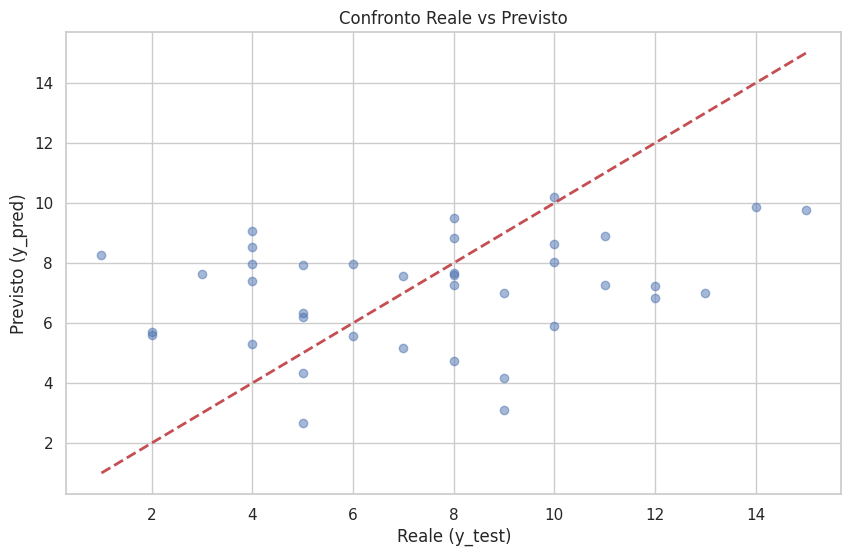

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Linea ideale
plt.xlabel('Reale (y_test)')
plt.ylabel('Previsto (y_pred)')
plt.title('Confronto Reale vs Previsto')
plt.show()